In [1]:
import paulssonlab.deaton.trenchripper.trenchripper as tr

import warnings

warnings.filterwarnings(action="once")

import matplotlib

matplotlib.rcParams["figure.figsize"] = [20, 10]

In [2]:
headpath = "/n/scratch2/de64/2019-05-31_validation_data/"

In [3]:
import skimage.transform as transform
import skimage as sk
from paulssonlab.deaton.trenchripper.trenchripper import kymo_handle,pandas_hdf5_handler,writedir

In [4]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max 
import dask.dataframe as dd

In [5]:
class fluo_segmentation:
    def __init__(self,bit_max=0,scale_timepoints=False,scaling_percentile=0.9,img_scaling=1.,smooth_sigma=0.75,niblack_scaling=1.,\
                 hess_pad=6,global_threshold=25,cell_otsu_scaling=1.,local_otsu_r=15,min_obj_size=30,distance_threshold=2):
        self.bit_max = bit_max
        
        self.scale_timepoints=scale_timepoints
        self.scaling_percentile=scaling_percentile
        
        self.img_scaling = img_scaling

        self.smooth_sigma = smooth_sigma
        
        self.niblack_scaling = niblack_scaling
        self.hess_pad = hess_pad
        
        self.global_threshold = global_threshold
        self.cell_otsu_scaling = cell_otsu_scaling
        self.local_otsu_r = local_otsu_r
        self.min_obj_size = min_obj_size
        
        self.distance_threshold = distance_threshold
        
    def to_8bit(self,img_arr,bit_max=None):
        img_max = np.max(img_arr)+0.0001
        if bit_max is None:
            max_val = img_max
        else:
            max_val = max(img_max,bit_max)
        min_val = np.min(img_arr)
#         min_val = np.min(img_arr)
        norm_array = (img_arr-min_val)/(max_val-min_val)
        norm_byte_array = sk.img_as_ubyte(norm_array)
        return norm_byte_array
    
    def scale_kymo(self,wrap_arr,percentile):
        perc_t = np.percentile(wrap_arr[:].reshape(wrap_arr.shape[0],-1),percentile,axis=1)
        norm_perc_t = perc_t/np.max(perc_t)
        scaled_arr = wrap_arr.astype(float)/norm_perc_t[:,np.newaxis,np.newaxis]
        scaled_arr[scaled_arr>255.] = 255.
        scaled_arr = scaled_arr.astype("uint8")
        return scaled_arr
    
    def get_eig_img(self,img_arr,edge_padding=6):
        inverted = sk.util.invert(img_arr)
        del img_arr
        inverted = np.pad(inverted, edge_padding, 'reflect')
        hessian = sk.feature.hessian_matrix(inverted,order="rc")
        del inverted
        eig_img = sk.feature.hessian_matrix_eigvals(hessian)
        del hessian
        eig_img = np.min(eig_img,axis=0)
        eig_img = eig_img[edge_padding:-edge_padding,edge_padding:-edge_padding]
        max_val,min_val = np.max(eig_img),np.min(eig_img)
        eig_img = self.to_8bit(eig_img)
        return eig_img
    
    def get_eig_mask(self,eig_img,niblack_scaling=1.):
        eig_thr = sk.filters.threshold_niblack(eig_img)*niblack_scaling
        eig_mask = eig_img>eig_thr
        return eig_mask
    
    def get_cell_mask(self,img_arr,global_threshold=50,cell_otsu_scaling=1.,local_otsu_r=15,min_obj_size=30):
        otsu_selem = sk.morphology.disk(local_otsu_r)
        thr = sk.filters.rank.otsu(img_arr,otsu_selem)
        del otsu_selem
        cell_mask = (img_arr>thr)*(img_arr>global_threshold)
        del img_arr
        cell_mask = sk.morphology.remove_small_objects(cell_mask,min_size=min_obj_size)
        cell_mask = sk.morphology.remove_small_holes(cell_mask)
        
        return cell_mask
        
    def segment(self,img_arr): #img_arr is t,y,x
        t_tot = img_arr.shape[0]
        img_arr = self.to_8bit(img_arr,self.bit_max)
        if self.scale_timepoints:
            img_arr = self.scale_kymo(img_arr,self.scaling_percentile)
        
        input_kymo = kymo_handle()
        input_kymo.import_wrap(img_arr)
        del img_arr
        
        input_kymo = input_kymo.return_unwrap()
        original_shape = input_kymo.shape 
        input_kymo = transform.rescale(input_kymo,self.img_scaling,anti_aliasing=False, preserve_range=True).astype("uint8")
        input_kymo = sk.filters.gaussian(input_kymo,sigma=self.smooth_sigma,preserve_range=True,mode='reflect').astype("uint8")
        
        eig_img = self.get_eig_img(input_kymo,edge_padding=self.hess_pad)
        eig_mask = self.get_eig_mask(eig_img,niblack_scaling=self.niblack_scaling)
        del eig_img
        
        cell_mask = self.get_cell_mask(input_kymo,global_threshold=self.global_threshold,\
                    cell_otsu_scaling=self.cell_otsu_scaling,local_otsu_r=self.local_otsu_r,\
                    min_obj_size=self.min_obj_size)
        del input_kymo
        
        dist_img = ndi.distance_transform_edt(cell_mask).astype("uint8")
        dist_mask = dist_img>self.distance_threshold
        marker_mask = dist_mask*eig_mask
        del dist_mask
        marker_mask = sk.measure.label(marker_mask)
        
        output_labels = watershed(-dist_img, markers=marker_mask, mask=cell_mask)

        del dist_img
        del marker_mask
        del cell_mask
        output_labels = sk.transform.resize(output_labels,original_shape,order=0,anti_aliasing=False, preserve_range=True).astype("uint32")
         
        output_kymo = kymo_handle()
        output_kymo.import_unwrap(output_labels,t_tot)
        del output_labels
        output_kymo = output_kymo.return_wrap()
        return output_kymo
    
class fluo_segmentation_cluster(fluo_segmentation):
    def __init__(self,headpath,paramfile=True,seg_channel="",bit_max=0,scale_timepoints=False,scaling_percentile=0.9,\
                 img_scaling=1.,smooth_sigma=0.75,niblack_scaling=1.,hess_pad=6,global_threshold=25,cell_otsu_scaling=1.,\
                 local_otsu_r=15,min_obj_size=30,distance_threshold=2):

        if paramfile:
            parampath = headpath + "/fluorescent_segmentation.par"
            with open(parampath, 'rb') as infile:
                param_dict = pickle.load(infile)
                
        seg_channel = param_dict["Segmentation Channel:"]
        bit_max = param_dict['8 Bit Maximum:']
        scale_timepoints = param_dict['Scale Fluorescence?']
        scaling_percentile = param_dict["Scaling Percentile:"]
        img_scaling = param_dict["Image Scaling Factor:"]
        smooth_sigma = param_dict['Gaussian Kernel Sigma:']
        global_threshold = param_dict['Global Threshold:']
        cell_otsu_scaling = param_dict['Cell Threshold Scaling:']
        local_otsu_r = param_dict['Local Otsu Radius:']
        min_obj_size = param_dict['Minimum Object Size:']        
        niblack_scaling = param_dict['Niblack Scaling:']
        distance_threshold = param_dict['Distance Threshold:']
                
        super(fluo_segmentation_cluster, self).__init__(bit_max=bit_max,scale_timepoints=scale_timepoints,scaling_percentile=scaling_percentile,\
                                                        img_scaling=img_scaling,smooth_sigma=smooth_sigma,niblack_scaling=niblack_scaling,\
                                                        hess_pad=hess_pad,global_threshold=global_threshold,cell_otsu_scaling=cell_otsu_scaling,\
                                                        local_otsu_r=local_otsu_r,min_obj_size=min_obj_size,distance_threshold=distance_threshold)

        self.headpath = headpath
        self.seg_channel = seg_channel
        self.kymographpath = headpath + "/kymograph"
        self.fluorsegmentationpath = headpath + "/fluorsegmentation"
        self.metapath = headpath + "/kymograph/metadata"

    def generate_segmentation(self,file_idx):
        with h5py.File(self.kymographpath + "/kymograph_" + str(file_idx) + ".hdf5","r") as input_file:
            input_data = input_file[self.seg_channel]
            trench_output = []
            for trench_idx in range(input_data.shape[0]):
                trench_array = input_data[trench_idx]
                trench_array = self.segment(trench_array)
                trench_output.append(trench_array[np.newaxis])
                del trench_array
        trench_output = np.concatenate(trench_output,axis=0)
        with h5py.File(self.fluorsegmentationpath + "/segmentation_" + str(file_idx) + ".hdf5", "w") as h5pyfile:
            hdf5_dataset = h5pyfile.create_dataset("data", data=trench_output, dtype="uint16")
        return file_idx
    
    def segmentation_completed(self,seg_future):
        return 0

    def dask_segment(self,dask_controller):
        writedir(self.fluorsegmentationpath,overwrite=True)
        dask_controller.futures = {}

        kymodf = dd.read_parquet(self.metapath)
        file_list = kymodf["File Index"].unique().compute().tolist()
        num_file_jobs = len(file_list)

        random_priorities = np.random.uniform(size=(num_file_jobs,))
        for k,file_idx in enumerate(file_list):
            priority = random_priorities[k]

            future = dask_controller.daskclient.submit(self.generate_segmentation,file_idx,retries=0,priority=priority)
            dask_controller.futures["Segmentation: " + str(file_idx)] = future
        for k,file_idx in enumerate(file_list):
            priority = random_priorities[k]

            future = dask_controller.daskclient.submit(self.segmentation_completed,dask_controller.futures["Segmentation: " + str(file_idx)],retries=0,priority=priority)
            dask_controller.futures["Segmentation Completed: " + str(file_idx)] = future
        gathered_tasks = dask_controller.daskclient.gather([dask_controller.futures["Segmentation Completed: " + str(file_idx)] for file_idx in file_list],errors="skip")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import h5py
import pickle
import copy
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Dropdown, IntText, SelectMultiple, Select, IntRangeSlider, FloatRangeSlider
from skimage import filters,transform
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

class fluo_segmentation_interactive(fluo_segmentation):

    def __init__(self,headpath,bit_max=0,scale_timepoints=False,scaling_percentile=0.9,img_scaling=1.,smooth_sigma=0.75,niblack_scaling=1.,\
                 hess_pad=6,global_threshold=25,cell_otsu_scaling=1.,local_otsu_r=15,min_obj_size=30,distance_threshold=2):

        fluo_segmentation.__init__(self,bit_max=bit_max,scale_timepoints=scale_timepoints,scaling_percentile=scaling_percentile,\
                                   img_scaling=img_scaling,smooth_sigma=smooth_sigma,niblack_scaling=niblack_scaling,\
                                  hess_pad=hess_pad,global_threshold=global_threshold,cell_otsu_scaling=cell_otsu_scaling,\
                                   local_otsu_r=local_otsu_r,min_obj_size=min_obj_size,distance_threshold=distance_threshold)

        self.headpath = headpath
        self.kymographpath = headpath + "/kymograph"
        self.metapath = headpath + "/kymograph/metadata"
#         self.metapath = headpath + "/metadata.hdf5"
        self.meta_handle = pandas_hdf5_handler(headpath + "/metadata.hdf5")
        self.kymodf = pd.read_parquet(self.metapath,columns=["timepoints","trenchid","File Index","File Trench Index"])
        
#         self.kymodf = self.meta_handle.read_df("kymograph",read_metadata=True)
        globaldf = self.meta_handle.read_df("global",read_metadata=True)
        self.all_channels = globaldf.metadata['channels']

        timepoint_num = len(self.kymodf["timepoints"].unique().tolist())
        self.t_range = (0,timepoint_num)
        self.trenchid_arr = self.kymodf["trenchid"].unique()
        self.kymodf = self.kymodf.set_index(["trenchid","timepoints"])

        self.final_params = {}

    def choose_seg_channel(self,seg_channel):
        self.seg_channel = seg_channel

    def choose_seg_channel_inter(self):
        choose_channel = interactive(self.choose_seg_channel,{"manual": True},\
        seg_channel=Dropdown(options=self.all_channels,value=self.all_channels[0]))
        display(choose_channel)

    def plot_img_list(self,img_list,cmap="Greys_r",interpolation=None):
        nrow = ((len(img_list)-1)//self.img_per_row)+1
        fig, axes = plt.subplots(nrows=nrow, ncols=self.img_per_row, figsize=self.fig_size)
        for i in range(len(img_list)):
            img = img_list[i]
            if nrow < 2:
                axes[i%self.img_per_row].imshow(img,cmap=cmap,interpolation=interpolation)
            else:
                axes[i//self.img_per_row,i%self.img_per_row].imshow(img,cmap=cmap,interpolation=interpolation)
        extra_slots = self.img_per_row - (len(img_list)%self.img_per_row)
        if extra_slots != 0:
            for slot in range(1,extra_slots+1):
                if nrow < 2:
                    axes[self.img_per_row-slot].axis('off')
                else:
                    axes[-1, self.img_per_row-slot].axis('off')
        plt.tight_layout()
        plt.show()

    def import_array(self,n_trenches,t_range=(0,None),t_subsample_step=1,fig_size_y=9,fig_size_x=6,img_per_row=2):
        self.fig_size = (fig_size_y,fig_size_x)
        self.img_per_row = img_per_row

        rand_trench_arr = np.random.choice(self.trenchid_arr,size=(n_trenches,),replace=False)
        self.selecteddf = self.kymodf.loc[list(zip(rand_trench_arr,np.zeros(len(rand_trench_arr)).astype(int)))]
        selectedlist = list(zip(self.selecteddf["File Index"].tolist(),self.selecteddf["File Trench Index"].tolist()))

        array_list = []
        for item in selectedlist:
            with h5py.File(self.kymographpath + "/kymograph_" + str(item[0]) + ".hdf5", "r") as hdf5_handle:
                if t_range[1] == None:
                    array = hdf5_handle[self.seg_channel][item[1],t_range[0]::t_subsample_step]
                else:
                    array = hdf5_handle[self.seg_channel][item[1],t_range[0]:t_range[1]+1:t_subsample_step]
            array_list.append(array)
        output_array = np.concatenate(np.expand_dims(array_list,axis=0),axis=0)
        self.t_tot = output_array.shape[1]
        self.plot_kymographs(output_array)
        self.output_array = output_array

        return output_array

    def import_array_inter(self):
        kymo_arr_int = interactive(self.import_array,{"manual": True},n_trenches=IntText(value=12,\
                       description="Number of trenches:", disabled=False),t_range=IntRangeSlider(value=[self.t_range[0],\
                       self.t_range[1] - 1],description="Time Range:",min=self.t_range[0],max=self.t_range[1] - 1,step=1,\
                       disabled=False),t_subsample_step=IntSlider(value=1, description="Time Subsampling Step:", min=1,\
                       max=20, step=1),fig_size_y=IntSlider(value=20, description="Figure Size (Y Dimension):", min=1,\
                       max=30, step=1),fig_size_x=IntSlider(value=12, description="Figure Size (X Dimension):", min=1,\
                       max=30, step=1),img_per_row=IntSlider(value=6, description="Images per Row:", min=1, max=30,\
                       step=1))
        display(kymo_arr_int)

    def plot_kymographs(self,kymo_arr):
        input_kymo = kymo_handle()
        img_list = []
        for k in range(kymo_arr.shape[0]):
            input_kymo.import_wrap(kymo_arr[k])
            img_list.append(input_kymo.return_unwrap())
        self.plot_img_list(img_list)
        return img_list

    def plot_processed(self,bit_max,scale_timepoints,scaling_percentile,img_scaling,smooth_sigma):
        
        self.final_params['8 Bit Maximum:'] = bit_max
        self.final_params['Scale Fluorescence?'] = scale_timepoints
        self.final_params["Scaling Percentile:"] = scaling_percentile
        self.final_params["Image Scaling Factor:"] = img_scaling
        self.final_params['Gaussian Kernel Sigma:'] = smooth_sigma
        
        output_array = copy.copy(self.output_array) #k,t,y,x
        
        percentile = int(np.percentile(output_array.flatten(), 99))
        print("99th percentile:" + str(percentile))
        fig, ax = plt.subplots(1, 1)
        ax.hist(output_array.flatten(),bins=50)
        ax.axvline(bit_max,c="r",linewidth=3,zorder=10)
        ax.set_title("Pixel Value Histogram w/ 8-bit Maximum",fontsize=20)
        ax.set_xlabel("Pixel Value",fontsize=15)
        fig.set_size_inches(9, 6)
        fig.show()
        
        output_array_list = []
        for k in range(output_array.shape[0]):
            scaled_output_array = self.to_8bit(output_array[k],bit_max)
            if scale_timepoints:
                scaled_output_array = self.scale_kymo(scaled_output_array,scaling_percentile)
            output_array_list.append(scaled_output_array)
        output_array = np.array(output_array_list)

#         proc_list = []
        unwrap_proc_list = []
        for k in range(output_array.shape[0]):
            t_tot = output_array[k].shape[0]
            output_array_unwrapped = kymo_handle()
            output_array_unwrapped.import_wrap(output_array[k])
            output_array_unwrapped = output_array_unwrapped.return_unwrap()
            rescaled_unwrapped = transform.rescale(output_array_unwrapped,img_scaling,anti_aliasing=False, preserve_range=True).astype("uint8")
            filtered_unwrapped = sk.filters.gaussian(rescaled_unwrapped,sigma=smooth_sigma,preserve_range=True,mode='reflect').astype("uint8")
#             filtered_wrapped = kymo_handle()
#             filtered_wrapped.import_unwrap(filtered_unwrapped,t_tot)
#             filtered_wrapped = filtered_wrapped.return_wrap()
#             proc_list.append(filtered_wrapped)
            unwrap_proc_list.append(filtered_unwrapped)
        self.proc_list = unwrap_proc_list
        del unwrap_proc_list
        self.eig_list = [self.get_eig_img(item,edge_padding=self.hess_pad) for item in self.proc_list]
        
        self.plot_img_list(self.proc_list)
        self.plot_img_list(self.eig_list)

    def plot_processed_inter(self):
        proc_list_int = interactive(
            self.plot_processed,
            {"manual": True},
            bit_max=IntSlider(
                value=1000,
                description="8-bit Maximum:",
                min=0,
                max=65535,
                step=250,
                disabled=False,
            ),
            scale_timepoints=Dropdown(
                options=[True, False],
                value=False,
                description="Scale Fluorescence?",
                disabled=False,
            ),
            scaling_percentile=IntSlider(
                value=90,
                description="Scaling Percentile:",
                min=0,
                max=100,
                step=1,
                disabled=False,
            ),
            img_scaling=FloatSlider(
                value=1.,
                description="Image Upsampling Factor:",
                min=1.,
                max=3.,
                step=0.25,
                disabled=False,
            ),
            smooth_sigma=FloatSlider(
                value=0.75,
                description="Gaussian Kernel Sigma:",
                min=0.0,
                max=3.0,
                step=0.25,
                disabled=False,
            ),
        )

        display(proc_list_int)
        
    def plot_cell_mask(self,global_threshold,cell_otsu_scaling,local_otsu_r,min_obj_size):
        self.final_params['Global Threshold:'] = global_threshold
        self.final_params['Cell Threshold Scaling:'] = cell_otsu_scaling
        self.final_params['Local Otsu Radius:'] = local_otsu_r
        self.final_params['Minimum Object Size:'] = min_obj_size
         
        proc_arr = np.array(self.proc_list)
        fig, ax = plt.subplots(1, 1)
        ax.hist(proc_arr.flatten(),bins=50)
        ax.axvline(global_threshold,c="r",linewidth=3,zorder=10)
        ax.set_title("Pixel Value Histogram w/ Global Threshold",fontsize=20)
        ax.set_xlabel("Pixel Value",fontsize=15)
        fig.set_size_inches(9, 6)
        fig.show()
        del proc_arr

        cell_mask_list = []
        for proc in self.proc_list:
            cell_mask = self.get_cell_mask(proc,global_threshold=global_threshold,cell_otsu_scaling=cell_otsu_scaling,\
                                           local_otsu_r=local_otsu_r,min_obj_size=min_obj_size)
            cell_mask_list.append(cell_mask)
        self.plot_img_list(self.proc_list)
        self.plot_img_list(cell_mask_list)
        self.cell_mask_list = cell_mask_list

    def plot_cell_mask_inter(self):
        cell_mask_list_int = interactive(
            self.plot_cell_mask,
            {"manual": True},
            global_threshold=IntSlider(
                value=50,
                description="Global Threshold:",
                min=0,
                max=255,
                step=1,
                disabled=False,
            ),
            cell_otsu_scaling=FloatSlider(
                value=1.,
                description="Cell Threshold Scaling:",
                min=0.0,
                max=2.0,
                step=0.01,
                disabled=False,
            ),
            local_otsu_r=IntSlider(
                value=15,
                description="Local Otsu Radius:",
                min=0,
                max=30,
                step=1,
                disabled=False,
            ),
            min_obj_size=IntSlider(
                value=30,
                description="Minimum Object Size:",
                min=0,
                max=100,
                step=2,
                disabled=False,
            ),
        )
        display(cell_mask_list_int)
        
    def plot_eig_mask(self,niblack_scaling):
        self.final_params['Niblack Scaling:'] = niblack_scaling
        
        eig_mask_list = []
        for eig in self.eig_list:
            eig_mask = self.get_eig_mask(eig,niblack_scaling=niblack_scaling)
            eig_mask_list.append(eig_mask)
            
        self.plot_img_list(self.eig_list)
        self.plot_img_list(eig_mask_list)
        
    def plot_eig_mask_inter(self):
        cell_eig_list_int = interactive(
            self.plot_eig_mask,
            {"manual": True},
            niblack_scaling=FloatSlider(
                value=1.,
                description="Edge Threshold Scaling:",
                min=0.0,
                max=2.0,
                step=0.01,
                disabled=False,
            ),
        )
        display(cell_eig_list_int)

    def plot_dist_mask(self,distance_threshold):
        self.final_params['Distance Threshold:'] = distance_threshold
        
        dist_img_list = []
        dist_mask_list = []
        for cell_mask in self.cell_mask_list:
            dist_img = ndi.distance_transform_edt(cell_mask).astype("uint8")
            dist_mask = dist_img>distance_threshold
            dist_img_list.append(dist_img)
            dist_mask_list.append(dist_mask)
            
        self.plot_img_list(dist_img_list)
        self.plot_img_list(dist_mask_list)
        self.dist_mask_list = dist_mask_list
        
    def plot_dist_mask_inter(self):
        dist_mask_int = interactive(
            self.plot_dist_mask,
            {"manual": True},
            distance_threshold=IntSlider(
                value=2,
                description="Distance Threshold:",
                min=0,
                max=20,
                step=1,
                disabled=False,
            ),
        )
        display(dist_mask_int)
        
    def plot_marker_mask(self,niblack_scaling,distance_threshold):      
        self.final_params['Niblack Scaling:'] = niblack_scaling
        self.final_params['Distance Threshold:'] = distance_threshold
        
        original_shape = (self.output_array.shape[2],self.output_array.shape[1]*self.output_array.shape[3]) #k,t,y,x
        segmentation_list = []
        for i in range(len(self.eig_list)):
            eig = self.eig_list[i]
            eig_mask = self.get_eig_mask(eig,niblack_scaling=niblack_scaling)
            
            cell_mask = self.cell_mask_list[i]
            dist_img = ndi.distance_transform_edt(cell_mask).astype("uint8")
            dist_mask = dist_img>distance_threshold
            
            marker_mask = dist_mask*eig_mask
            marker_mask = sk.measure.label(marker_mask)
            output_labels = watershed(-dist_img, markers=marker_mask, mask=cell_mask)
            
            output_labels = sk.transform.resize(output_labels,original_shape,order=0,anti_aliasing=False, preserve_range=True).astype("uint32")
            segmentation_list.append(output_labels)
            
        self.plot_kymographs(self.output_array)
        
        seg_plt_list = []
        for segmentation in segmentation_list:
            plt_mask = (segmentation == 0)
            plt_img = np.ma.array(segmentation, mask=plt_mask)
            seg_plt_list.append(plt_img)        
        self.plot_img_list(seg_plt_list,cmap="jet",interpolation='nearest')
        
    def plot_marker_mask_inter(self):
        if self.final_params['Niblack Scaling:'] is not None\
        and self.final_params['Distance Threshold:'] is not None:  
            marker_mask_int = interactive(
                self.plot_marker_mask,
                {"manual": True},
                niblack_scaling=FloatSlider(
                    value=self.final_params['Niblack Scaling:'],
                    description="Edge Threshold Scaling:",
                    min=0.0,
                    max=2.0,
                    step=0.01,
                    disabled=False,
                ),
                distance_threshold=IntSlider(
                    value=self.final_params['Distance Threshold:'],
                    description="Distance Threshold:",
                    min=0,
                    max=20,
                    step=1,
                    disabled=False,
                ),
            )
        else:        
            marker_mask_int = interactive(
                self.plot_marker_mask,
                {"manual": True},
                niblack_scaling=FloatSlider(
                    value=1.,
                    description="Edge Threshold Scaling:",
                    min=0.0,
                    max=2.0,
                    step=0.01,
                    disabled=False,
                ),
                distance_threshold=IntSlider(
                    value=2,
                    description="Distance Threshold:",
                    min=0,
                    max=20,
                    step=1,
                    disabled=False,
                ),
            )
        display(marker_mask_int)
        
    def process_results(self):
        self.final_params["Segmentation Channel:"] = self.seg_channel
        for key,value in self.final_params.items():
            print(key + " " + str(value))

    def write_param_file(self):
        with open(self.headpath + "/fluorescent_segmentation.par", "wb") as outfile:
            pickle.dump(self.final_params, outfile)
        
#     def plot_threshold_result(self,edge_threshold_scaling,min_obj_size):
#         composite_mask_list = []
#         edge_mask_list = []
#         for i,min_eigvals in enumerate(self.eigval_list):
#             cell_mask = self.cell_mask_list[i]

#             edge_threshold = self.get_mid_threshold_arr(min_eigvals,edge_threshold_scaling=edge_threshold_scaling,padding=self.wrap_pad)

#             cell_mask_kymo = kymo_handle()
#             cell_mask_kymo.import_wrap(cell_mask)
#             cell_mask = cell_mask_kymo.return_unwrap(padding=self.wrap_pad)

#             min_eigvals_kymo = kymo_handle()
#             min_eigvals_kymo.import_wrap(min_eigvals)
#             min_eigvals = min_eigvals_kymo.return_unwrap(padding=self.wrap_pad)

#             composite_mask = self.find_mask(cell_mask,min_eigvals,edge_threshold,min_obj_size=min_obj_size)
#             composite_mask_list.append(composite_mask)

#         self.plot_img_list(composite_mask_list)
#         self.composite_mask_list = composite_mask_list

#     def plot_threshold_result_inter(self):
#         composite_mask_list_int = interactive(
#             self.plot_threshold_result,
#             {"manual": True},
#             edge_threshold_scaling=FloatSlider(
#                 value=1.0,
#                 description="Edge Threshold Scaling",
#                 min=0.0,
#                 max=2.0,
#                 step=0.01,
#                 disabled=False,
#             ),
#             min_obj_size=IntSlider(
#                 value=30,
#                 description="Minimum Object Size:",
#                 min=0,
#                 max=100,
#                 step=2,
#                 disabled=False,
#             ),
#         )
#         display(composite_mask_list_int)


#     def plot_scores(self,edge_threshold_scaling,threshold_step_perc,threshold_perc_num_steps,min_obj_size):
#         self.final_params['Edge Threshold Scaling:'] = edge_threshold_scaling
#         self.final_params['Threshold Step Percent:'] = threshold_step_perc
#         self.final_params['Number of Threshold Steps:'] = threshold_perc_num_steps
#         self.final_params['Minimum Object Size:'] = min_obj_size

#         conv_scores_list = []
#         for i,min_eigvals in enumerate(self.eigval_list):
#             cell_mask = self.cell_mask_list[i]

#             mid_threshold_arr = self.get_mid_threshold_arr(min_eigvals,edge_threshold_scaling=edge_threshold_scaling,padding=self.wrap_pad)

#             cell_mask_kymo = kymo_handle()
#             cell_mask_kymo.import_wrap(cell_mask)
#             cell_mask = cell_mask_kymo.return_unwrap(padding=self.wrap_pad)

#             min_eigvals_kymo = kymo_handle()
#             min_eigvals_kymo.import_wrap(min_eigvals)
#             min_eigvals = min_eigvals_kymo.return_unwrap(padding=self.wrap_pad)

#             conv_scores = self.get_scores(cell_mask,min_eigvals,mid_threshold_arr,\
#                                           threshold_step_perc=threshold_step_perc,threshold_perc_num_steps=threshold_perc_num_steps,min_obj_size=min_obj_size)
#             conv_scores_list.append(conv_scores)
#         self.plot_img_list(conv_scores_list)
#         self.conv_scores_list = conv_scores_list

#     def plot_scores_inter(self):
#         conv_scores_list_int = interactive(
#             self.plot_scores,
#             {"manual": True},
#             edge_threshold_scaling=FloatSlider(
#                 value=0.9,
#                 description="Edge Threshold Scaling",
#                 min=0.0,
#                 max=2.0,
#                 step=0.01,
#                 disabled=False,
#             ),
#             threshold_step_perc=FloatSlider(
#                 value=0.05,
#                 description="Threshold Step Percent",
#                 min=0.0,
#                 max=0.5,
#                 step=0.01,
#                 disabled=False,
#             ),
#             threshold_perc_num_steps=IntSlider(
#                 value=2,
#                 description="Number of Threshold Steps",
#                 min=0,
#                 max=5,
#                 step=1,
#                 disabled=False,
#             ),
#             min_obj_size=IntSlider(
#                 value=30,
#                 description="Minimum Object Size:",
#                 min=0,
#                 max=100,
#                 step=2,
#                 disabled=False,
#             ),
#         )
#         display(conv_scores_list_int)

#     def plot_final_mask(self,convex_threshold):
#         self.final_params['Convexity Threshold:'] = convex_threshold
#         img_scaling = self.final_params["Image Scaling Factor:"]

#         final_mask_list = []
#         for conv_scores in self.conv_scores_list:
#             final_mask = (conv_scores>convex_threshold)
#             final_mask_new = []
#             for t in range(final_mask.shape[0]):
#                 image_rescaled = transform.rescale(final_mask[t], 1./img_scaling, anti_aliasing=False,order=0,preserve_range=True)
#                 final_mask_new.append(image_rescaled)
#             del final_mask
#             final_mask = np.array(final_mask_new,dtype=bool)
#             final_mask = sk.measure.label(final_mask)
#             final_mask_list.append(final_mask)
        
#         self.plot_img_list(final_mask_list)
#         self.final_mask_list = final_mask_list

#     def plot_final_mask_inter(self):
#         final_mask_list_int = interactive(
#             self.plot_final_mask,
#             {"manual": True},
#             convex_threshold=FloatSlider(
#                 value=0.75,
#                 description="Convexity Threshold:",
#                 min=0.0,
#                 max=1.0,
#                 step=0.01,
#                 disabled=False,
#             ),
#         )
#         display(final_mask_list_int)

#     def process_results(self):
#         self.final_params["Segmentation Channel:"] = self.seg_channel
#         for key,value in self.final_params.items():
#             print(key + " " + str(value))

#     def write_param_file(self):
#         with open(self.headpath + "/fluorescent_segmentation.par", "wb") as outfile:
#             pickle.dump(self.final_params, outfile)


In [30]:
inter_test = fluo_segmentation_interactive(headpath)

In [31]:
inter_test.choose_seg_channel_inter()

interactive(children=(Dropdown(description='seg_channel', options=('Phase', 'GFP'), value='Phase'), Button(des…

In [32]:
inter_test.import_array_inter()

interactive(children=(IntText(value=12, description='Number of trenches:'), IntRangeSlider(value=(0, 70), desc…

In [33]:
inter_test.plot_processed_inter()

interactive(children=(IntSlider(value=1000, description='8-bit Maximum:', max=65535, step=250), Dropdown(descr…

In [34]:
inter_test.plot_cell_mask_inter()

interactive(children=(IntSlider(value=50, description='Global Threshold:', max=255), FloatSlider(value=1.0, de…

In [21]:
inter_test.plot_eig_mask_inter()

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling:', max=2.0, step=0.01), Butto…

In [22]:
inter_test.plot_dist_mask_inter()

interactive(children=(IntSlider(value=2, description='Distance Threshold:', max=20), Button(description='Run I…

In [23]:
inter_test.plot_marker_mask_inter()

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling:', max=2.0, step=0.01), IntSl…

In [24]:
inter_test.process_results()

8 Bit Maximum: 2500
Scale Fluorescence? False
Scaling Percentile: 90
Image Scaling Factor: 1.0
Gaussian Kernel Sigma: 1.0
Global Threshold: 50
Cell Threshold Scaling: 1.0
Local Otsu Radius: 15
Minimum Object Size: 30
Niblack Scaling: 1.0
Distance Threshold: 2
Segmentation Channel: GFP


In [26]:
inter_test.write_param_file()

In [7]:
dask_controller = tr.trcluster.dask_controller(
    walltime="01:00:00",
    local=False,
    n_workers=20,
    memory="1GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

In [8]:
dask_controller.displaydashboard()

In [9]:
segment = fluo_segmentation_cluster(headpath, paramfile=True)

In [10]:
segment.dask_segment(dask_controller)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
import h5py

In [25]:
with h5py.File("/n/scratch2/de64/2019-05-31_validation_data/fluorsegmentation/segmentation_10.hdf5","r") as infile:
    data = infile['data'][:]
with h5py.File("/n/scratch2/de64/2019-05-31_validation_data/kymograph/kymograph_10.hdf5","r") as infile:
    img_data = infile['GFP'][:]

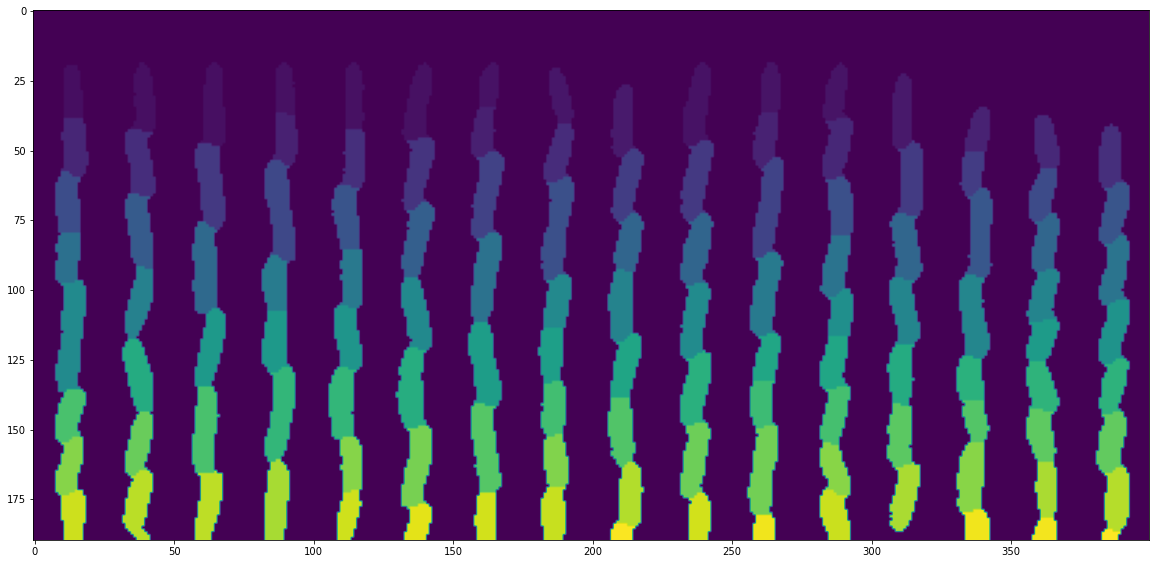

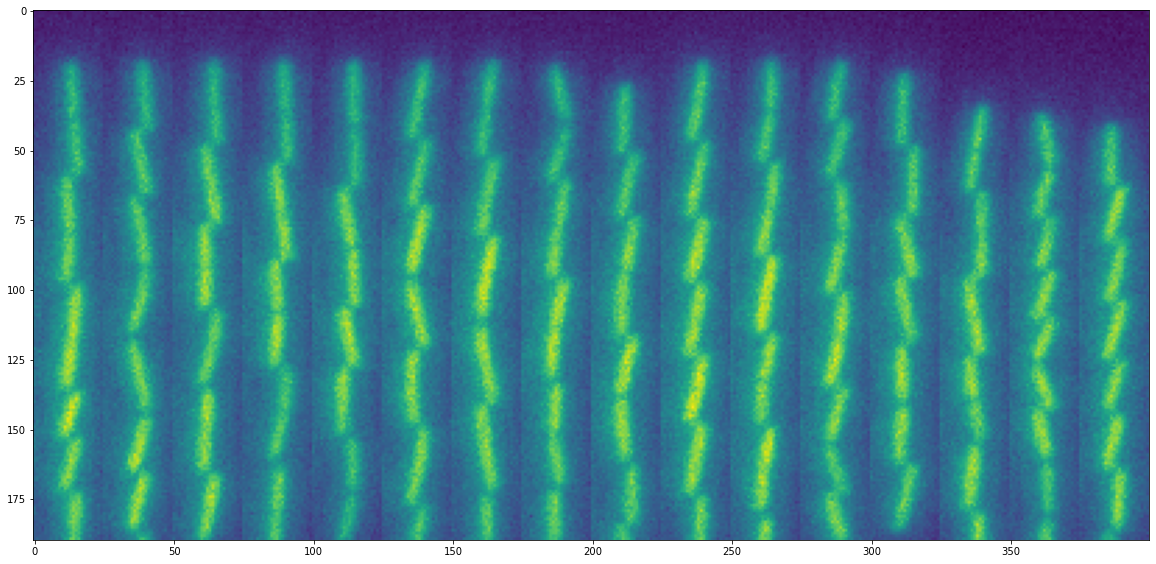

In [26]:
moo = tr.kymo_handle()
moo.import_wrap(data[0])
plt.imshow(moo.return_unwrap()[:,:400])
plt.show()
moo = tr.kymo_handle()
moo.import_wrap(img_data[0])
plt.imshow(moo.return_unwrap()[:,:400])
plt.show()